In [25]:
import os
print(os.listdir("../input"))
print(os.listdir("../input/keras-pretrained-models/"))
data_dir = '../input/5-celebrity-faces-dataset/data'
vgg16weight = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50weight = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

['5-celebrity-faces-dataset', 'keras-pretrained-models']
['inception_v3_weights_tf_dim_ordering_tf_kernels.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels.h5', 'imagenet_class_index.json', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5', 'Kuszma.JPG', 'xception_weights_tf_dim_ordering_tf_kernels.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5']


In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop, SGD
from keras import backend as K
import keras
import matplotlib.pyplot as plt

In [27]:
img_width, img_height = 200, 200
train_data_dir = os.path.join(data_dir, 'train')
validation_data_dir = os.path.join(data_dir, 'val')
nb_train_samples = 93
nb_validation_samples = 25
epochs = 50
batch_size = 16
numclasses = 5

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,  
    zoom_range = 0.1,  
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    vertical_flip=False,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [5]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [28]:
def vgg16CNNtl(input_shape, outclass, sigma='sigmoid'):    
    base_model = None
    base_model = keras.applications.VGG16(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(vgg16weight)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))
    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))    
    return model
 
def resnet50tl(input_shape, outclass, sigma='sigmoid'):    
    base_model = None
    base_model = keras.applications.resnet50.ResNet50(weights=None, include_top=False, input_shape=input_shape)
    base_model.load_weights(resnet50weight)    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    for i in range(2):
        top_model.add(Dense(4096, activation='relu'))
        top_model.add(Dropout(0.5))
    top_model.add(Dense(outclass, activation=sigma))
    model = None
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))    
    return model

In [7]:
model = vgg16CNNtl(input_shape, numclasses, 'softmax')
lr = 1e-5
decay = 1e-7
optimizer = RMSprop(lr=lr, decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [8]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
5/5 [==============================] - 2s 456ms/step - loss: 2.0490 - accuracy: 0.2078 - val_loss: 1.6445 - val_accuracy: 0.1250
Epoch 2/50
5/5 [==============================] - 1s 228ms/step - loss: 1.7580 - accuracy: 0.2727 - val_loss: 1.5614 - val_accuracy: 0.3750
Epoch 3/50
5/5 [==============================] - 1s 268ms/step - loss: 1.5749 - accuracy: 0.2727 - val_loss: 1.4560 - val_accuracy: 0.4375
Epoch 4/50
5/5 [==============================] - 1s 223ms/step - loss: 1.5513 - accuracy: 0.3117 - val_loss: 1.4408 - val_accuracy: 0.3750
Epoch 5/50
5/5 [==============================] - 1s 242ms/step - loss: 1.7047 - accuracy: 0.2987 - val_loss: 1.4606 - val_accuracy: 0.3125
Epoch 6/50
5/5 [==============================] - 1s 213ms/step - loss: 1.6274 - accuracy: 0.2597 - val_loss: 1.2699 - val_accuracy: 0.6250
Epoch 7/50
5/5 [==============================] - 1s 218ms/step - loss: 1.3980 - accuracy: 0.4545 - val_loss: 1.2420 - val_accuracy: 0.5000
Epoch 8/50
5/5 [====

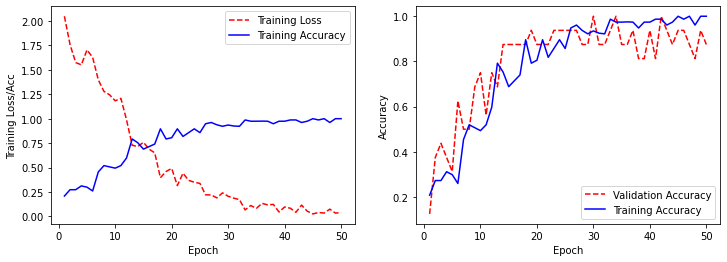

In [29]:
training_loss = history.history['loss']
training_acc = history.history['accuracy']
epoch_count = range(1, len(training_loss) + 1)
fig=plt.figure(figsize=(12, 4))
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')
val_acc = history.history['val_accuracy']
training_acc = history.history['accuracy']
epoch_count = range(1, len(val_acc) + 1)
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [22]:
saveweight =  'celebriytag_weight.h5'
model.save_weights(saveweight)

In [23]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import cv2
import requests
import os

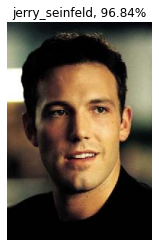

In [24]:
labels = ['ben_afflek',  'elton_john',  'jerry_seinfeld',  'madonna',  'mindy_kaling']
test_imgs = ['ben_afflek/httpabsolumentgratuitfreefrimagesbenaffleckjpg.jpg']
for test in test_imgs:
    test_img = os.path.join(validation_data_dir, test)
    img = image.load_img(test_img, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.
    classes = model.predict(x)
    result = np.squeeze(classes)
    result_indices = np.argmax(result)    
    img = cv2.imread(test_img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.title("{}, {:.2f}%".format(labels[result_indices], result[result_indices]*100))
    plt.imshow(img)